In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output

## Download the Oxford-IIIT Pets dataset

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

In [6]:
#     The following code performs a simple augmentation of flipping an image. In addition, image is normalized to [0,1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [8]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], [128, 128])
    input_mask = tf.image.resize(datapoint['segmentation_mask'], [128, 128])
    
    if tf.random.unifom(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [9]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], [128, 128])
    input_mask = tf.image.resize(datapoint['segmentation_mask'], [128, 128])
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
test_dataset = test.batch(BATCH_SIZE)

## Define the model

In [27]:
OUTPUT_CHANNELS = 3

In [31]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',  # 64 x 64
    'block_3_expand_relu',  # 32 x 32
    'block_6_expand_relu',  # 16 x 16
    'block_13_expand_relu', # 8 x 8 
    'block_16_project'      # 4 x 4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [36]:
from tensorflow_examples.models.pix2pix import pix2pix

In [39]:
# Upsamples an input
# Conv2DTranspose => Batchnorm => Dropout => Relu
up_stack = [
    pix2pix.upsample(filters=512, size=3),   # 4 x 4 -> 8 x 8
    pix2pix.upsample(filters=256, size=3),   # 8 x 8 -> 16 x 16
    pix2pix.upsample(filters=128, size=3),   # 16 x 16 -> 32 x 32
    pix2pix.upsample(filters=64, size=3)     # 32 x 32 -> 64 x 64
]

In [96]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs
    
    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1] # output shape [4 x 4 x 320] activations
    skips = reversed(skips[:-1]) # new skips of shape [8x8, 16x16, 32x32, 64x64]
    
    # Upsampling and establishing the skip conections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels,
        kernel_size=3,
        strides=2,
        padding='same' # 64 x 64 -> 128 x 128
    )
    x = last(x) # output [128 x 128 x 3], 3 is the number of classes
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [97]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

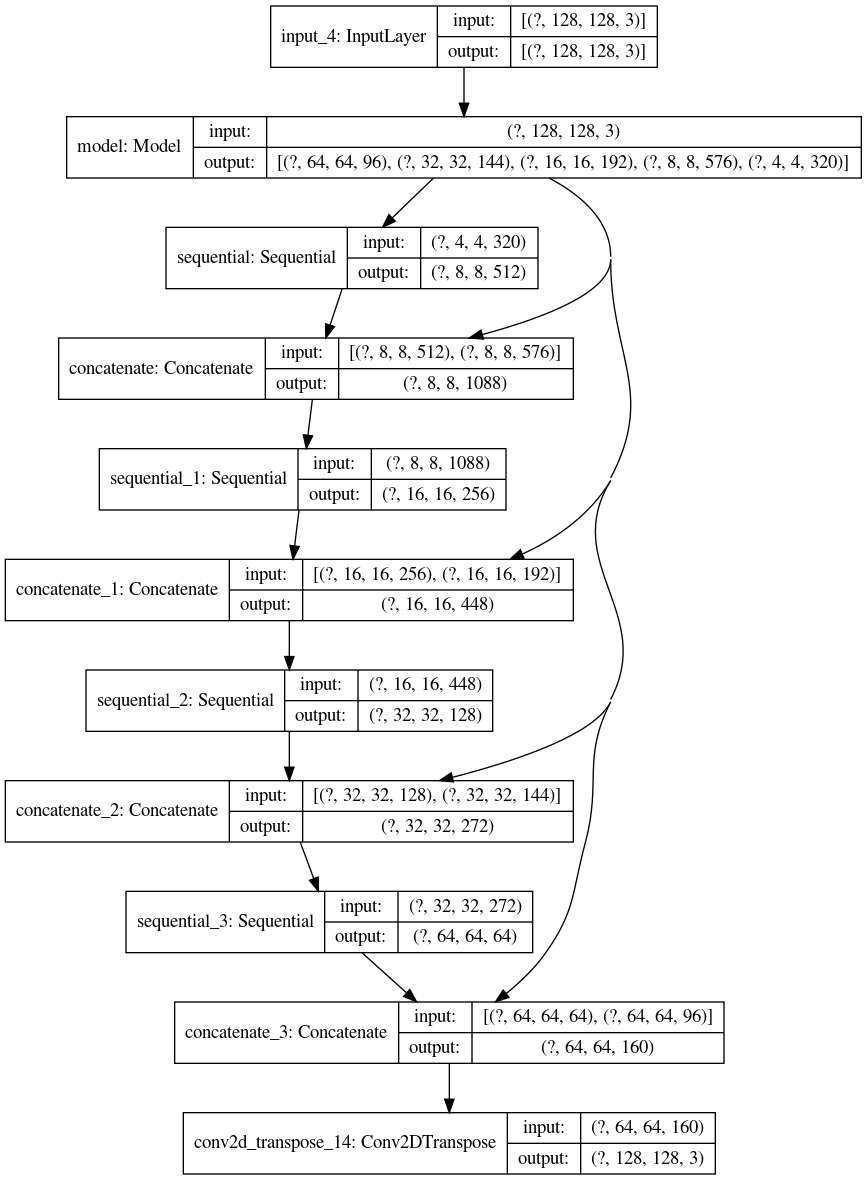

In [100]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
def create_maske(pred_mask):
    # pred_mask incliudes batch_size dimension (1)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxisw]
    return pred_mask[0]

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
TOTAL_VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE
# Every VALIDATION_STEPS, stop validating and draw result of validation
VALIDATION_STEPS = TOTAL_VALIDATION_STEPS // VAL_SUBSPLITS

model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_dataset,
    validation_steps=VALIDATION_STEPS
)

## Make predictions

In [105]:
def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])